## FLORENCE

**Importing Libraries**

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib


**Load .csv dataset**

In [30]:
# Load the Florence Airbnb dataset
df = pd.read_csv('../data/florence.csv')
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (13043, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,31840,https://www.airbnb.com/rooms/31840,20250619031413,6/19/2025,city scrape,Residenza Martin Classic room,"Nice, private and quiet double room, classic s...",NaN,https://a0.muscache.com/pictures/prohost-api/H...,380378,...,4.91,4.89,4.65,IT048017B4R5K5BW8E,t,24,14,10,0,0.85
1,32180,https://www.airbnb.com/rooms/32180,20250619031413,6/19/2025,city scrape,Charming Gem - Oltrarno City centre,.,NaN,https://a0.muscache.com/pictures/bcb23395-7215...,13925330,...,4.70,4.81,4.84,IT048017C232S8WUEN,f,1,1,0,0,0.22
2,39115,https://www.airbnb.com/rooms/39115,20250619031413,6/19/2025,previous scrape,Central Double Shared Bathroom,"Double Room Shared Bathroom: comfortable, larg...","San Lorenzo Church, the market and Cappelle Me...",https://a0.muscache.com/pictures/17793998/5f09...,167739,...,4.74,4.91,4.54,IT048017B9LED47MUB,f,11,3,8,0,0.48
3,39165,https://www.airbnb.com/rooms/39165,20250619031413,6/19/2025,previous scrape,Florence Central Double Private Bathroom,"Double room private bathroom: comfortable, lar...","San Lorenzo Church, the market and Cappelle Me...",https://a0.muscache.com/pictures/7e94f597-ac04...,167739,...,4.64,4.95,4.41,IT048017B9LED47MUB,f,11,3,8,0,0.14
4,39822,https://www.airbnb.com/rooms/39822,20250619031413,6/19/2025,city scrape,Apartment Santa Monaca Oltrarno old town,Location details.<br />The bridge right next t...,NaN,https://a0.muscache.com/pictures/51118538/b6b9...,154769,...,4.71,4.87,4.48,IT048017C2VVSRW6CW,f,3,3,0,0,0.19


**Separate features needed/extra + cleaning some columns**

In [31]:
columns_needed = [
    'price', 'room_type', 'accommodates', 'bedrooms', 'bathrooms',
    'review_scores_rating', 'number_of_reviews', 'neighbourhood_cleansed',
    'property_type', 'beds', 'review_scores_cleanliness',
    'review_scores_location', 'instant_bookable', 'reviews_per_month',
    'latitude', 'longitude',
]

df = df[columns_needed].copy()

# Select only the necessary features for prediction
required = ['accommodates', 'bedrooms', 'bathrooms', 'room_type', 'property_type', 'beds']
optional = ['beds', 'review_scores_rating', 'number_of_reviews',
            'review_scores_cleanliness', 'review_scores_location',
            'instant_bookable', 'reviews_per_month']

# Drop rows missing required values
df = df.dropna(subset=required)

# Fill optional ones with defaults (could be median or 0)
df[optional] = df[optional].fillna(0)

#for clustering:
from sklearn.cluster import KMeans

# Cluster latitude and longitude into 10 regions
kmeans = KMeans(n_clusters=5, random_state=42)
df["location_cluster"] = kmeans.fit_predict(df[["latitude", "longitude"]])
# Drop unnecessary columns
df = df.drop(columns=['latitude', 'longitude'])

df = pd.get_dummies(df, columns=[
    'room_type', 'neighbourhood_cleansed', 'property_type',
    'location_cluster'
])

# Clean the price column
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['instant_bookable'] = df['instant_bookable'].map({'t': 1, 'f': 0})

df = df[df['price'] > 0]

'''df = df[df['price'] > 20]
df = df[df['price'] < 1000]'''

# Feature engineering
df["beds_per_person"] = df["beds"] / df["accommodates"]
df["reviews_density"] = df["number_of_reviews"] / (df["reviews_per_month"] + 0.1)
''' Optional: df['number_of_reviews'] = np.log1p(df['number_of_reviews'])'''

categorical_cols = df.select_dtypes(include='object').columns.tolist()

df['log_price'] = np.log1p(df['price'])  # log(1 + price)


# One-hot encode 'room_type'
#df = pd.get_dummies(df, columns=['room_type', 'neighbourhood_cleansed'], drop_first=True)

df.head()


,price,accommodates,bedrooms,bathrooms,review_scores_rating,number_of_reviews,beds,review_scores_cleanliness,review_scores_location,instant_bookable,...,property_type_Tiny home,property_type_Tower,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,beds_per_person,reviews_density,log_price
0,130.0,2,1.0,1.0,4.67,156,1.0,4.85,4.89,1,...,False,False,False,False,False,False,True,0.50,164.210526,4.875197
1,112.0,4,2.0,2.0,4.77,40,3.0,4.84,4.81,0,...,False,False,True,False,False,False,False,0.75,125.000000,4.727388
4,97.0,4,2.0,1.0,4.48,34,2.0,4.45,4.87,0,...,False,False,True,False,False,False,False,0.50,117.241379,4.584967
5,215.0,2,2.0,1.0,4.75,8,1.0,4.50,4.88,1,...,False,False,False,False,False,False,True,0.50,50.000000,5.375278
6,173.0,4,1.0,1.0,4.86,441,2.0,4.87,4.91,0,...,False,False,True,False,False,False,False,0.50,171.595331,5.159055


**Separate training/testing sets**

In [32]:
X = df.drop("price", axis=1)
y = np.log1p(df['price'])

**Hyperparameter Tuning (for training process)**

In [33]:
X = X.select_dtypes(include=["number"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

import json

with open('../backend/api/models/feature_columns.json', 'w') as f:
    json.dump(X.columns.tolist(), f)

defaults = {
    col: float(df[col].mean()) if np.issubdtype(df[col].dtype, np.number) else 0
    for col in X.columns
}

with open('../backend/api/models/feature_defaults.json', 'w') as f:
    json.dump(defaults, f)



**XGBRegressor Model (training)**

In [34]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

xgb = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42
)

random_search.fit(X, y)
model = random_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


**Scores (for predictions)**

In [35]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)  # if y_test was log-transformed

print("MAE:", mean_absolute_error(y_test_real, y_pred))

MAE: 2.668714347136231


**Matplot diagram**

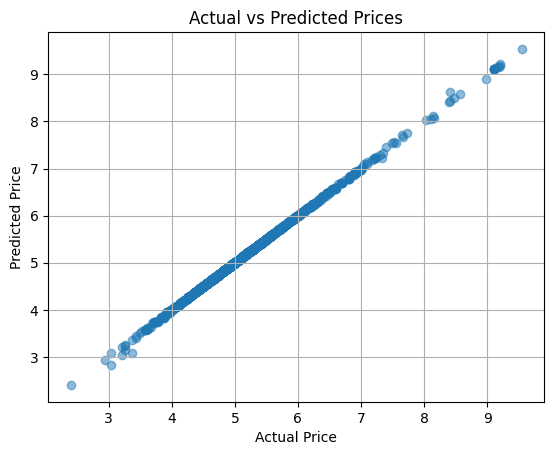

In [36]:
import matplotlib.pyplot as plt

plt.scatter(y_test, preds, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.grid(True)
plt.show()


**Saving the model**

In [37]:
joblib.dump(model, '../backend/api/models/florence_model.pkl')
print("Model saved to ./florence_model.pkl")


Model saved to ./florence_model.pkl
